In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')

In [2]:
# import cuml
import muon as mu
import itertools
from matplotlib.colors import CenteredNorm, Normalize
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import torch
from anndata import AnnData
import seaborn as sns
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from PIL import Image
from collections import OrderedDict
from scipy.stats import pearsonr
import squidpy as sq
from sklearn.metrics import adjusted_rand_score, jaccard_score, mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import timm
import itertools
from adjustText import adjust_text
import anndata as ad
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import itertools
from collections import Counter
import pickle

In [3]:
from pipelines.load import LoadCytAssistPipeline, LoadVisiumPipeline, LoadSeuratTonsilsPipeline
from pipelines.featurize import FeaturizePipeline
from pipelines.train import TrainModelPipeline
from pipelines.infer import InferencePipeline

from utils import cluster, align_adata, column_corr, floatify, tocpu, alpha_shape
from utils import alpha_shape

In [4]:
tissue = 'Tonsil'
antibody_panel = pd.read_csv('../antibody_panel.csv')
adata_annot = sc.read_h5ad("../adata/tonsil_cytassist.h5ad")
data_path = '../data/TonsilTissue'
data_path = f'../data/{tissue}Tissue'
with open('st_tonsil_data.pickle', 'rb') as handle:
    embed_dict = pickle.load(handle)

train_loader = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    sample_id = 0,
    name = 'Tonsil 1',
    celltypes = adata_annot.obs.celltype
)

eval_loader = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX_2/filtered_feature_bc_matrix.h5',
    sample_id = 1,
    name = 'Tonsil 2',
)

tonsils_loader = LoadSeuratTonsilsPipeline(
    path='/ix/hosmanbeyoglu/kor11/CytAssist/Tonsil/tonsils_st/'
)

In [5]:
def cluster_adata(adata, targets, titles, k):
    for emb, title in zip(targets, titles):
        if title+'_colors' in adata.uns: 
            adata.uns.pop(title+'_colors')
        km = KMeans(n_clusters=k, random_state=1).fit(emb)
        adata.obs[title] = km.labels_
        adata.obs[title] = adata.obs[title].astype('category')   

    return adata

def get_enriched_cluster(adx, layer, 
        anot='annotation_20220215', 
        targets=['Germinal Center', 'Proliferating Follicle']):
    gcs = adx[adx.obs[
        anot].isin(targets)].obs.index
    return adx[gcs, :].obs[layer].value_counts().sort_values().index[-1]

def gc_metrics(aax):
    scores = []
    gt = (aax.obs['annotation_20220215'].isin(['Germinal Center', 'Proliferating Follicle'])).values.astype(int)
    # gt = (aax.obs['annotation_20220215'].isin(['Germinal Center'])).values.astype(int)
    
    for layer in titles:
        gc_cluster = get_enriched_cluster(aax, layer=layer)
        predicted_gc = aax.obs[layer].isin([gc_cluster]).values.astype(int)
        jc = jaccard_score(gt, predicted_gc)
        nmi = normalized_mutual_info_score(gt, predicted_gc)
        ari = adjusted_rand_score(gt, predicted_gc)
        scores.append((ari, jc, nmi))

    df = pd.DataFrame(scores, 
            index=titles, columns=['ARI', 'JI', 'NMI']).sort_values(
            by='ARI', ascending=False)
    
    return df

In [7]:
ix = 2
adata_test = tonsils_loader.run(ix)

In [8]:
dfs = []
for i in tqdm(range(8)):
    titles = list(embed_dict[f'sample_{i}'].keys())
    targets = list(embed_dict[f'sample_{i}'].values())
    adata_test = tonsils_loader.run(i)
    aax = cluster_adata(adata_test.copy(), targets, titles, k=6)
    dfs.append(gc_metrics(aax))

dfx = pd.concat(dfs, axis=1)

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


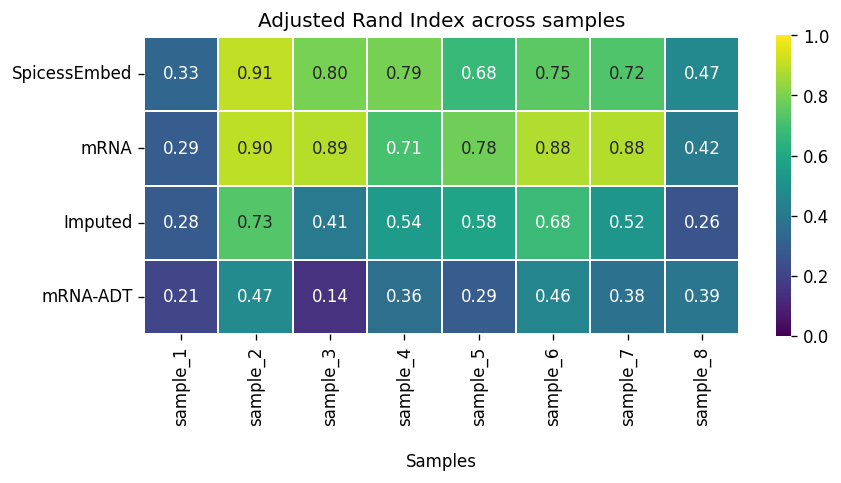

In [9]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 120

sns.heatmap(pd.DataFrame(dfx['ARI'].values, index=dfx.index, 
                        columns=[[f'sample_{x+1}' for x in range(8)]]), square=True, cbar=True, annot=True,
               cmap='viridis',  
                # norm=CenteredNorm(), 
            norm=Normalize(0, 1),
            linewidth=1, linecolor='white',
               cbar_kws={"orientation": "vertical", "shrink": 0.65}, fmt='.2f')

plt.title('Adjusted Rand Index across samples')
plt.xlabel('\nSamples')
plt.show()

In [10]:
def edges_around(adata_tmp, sections, alpha=5.5, dt=1):
    points = np.asarray(
        adata_tmp[adata_tmp.obs[
        'annotation_20220215'].isin(sections)].obsm[
        'spatial']*adata_tmp.uns['spatial'][list(
            adata_tmp.uns['spatial'].keys())[0]]['scalefactors']['tissue_hires_scalef'])
    points = np.vstack((points +[-dt,dt], points +[-dt,-dt], points +[dt,dt], points +[dt,-dt]))
    return alpha_shape(points, alpha=alpha, only_outer=True)


def find_edges(adata_tmp, sections, dt=1, alpha=5.5):
    points = np.asarray(
    adata_tmp[adata_tmp.obs[
    'annotation_20220215'].isin(sections)].obsm[
    'spatial']*adata_tmp.uns['spatial'][list(
        adata_tmp.uns['spatial'].keys())[0]]['scalefactors']['tissue_hires_scalef'])
    points = np.vstack((points +[-dt,dt], points +[-dt,-dt], points +[dt,dt], points +[dt,-dt]))
    edges =  alpha_shape(points, alpha=alpha, only_outer=True)
    return points, edges

In [11]:
ix = 1
adata_tmp = tonsils_loader.run(ix)
titles = list(embed_dict[f'sample_{ix}'].keys())
targets = list(embed_dict[f'sample_{ix}'].values())
adata_tmp = cluster_adata(adata_tmp.copy(), targets, titles, k=6)

In [13]:
metrics = gc_metrics(adata_tmp)
metrics.sort_values(by='ARI', ascending=False)

,ARI,JI,NMI
SpicessEmbed,0.905121,0.875000,0.798496
mRNA,0.899213,0.869110,0.804017
Imputed,0.732411,0.683036,0.566117
mRNA-ADT,0.473692,0.434615,0.274534


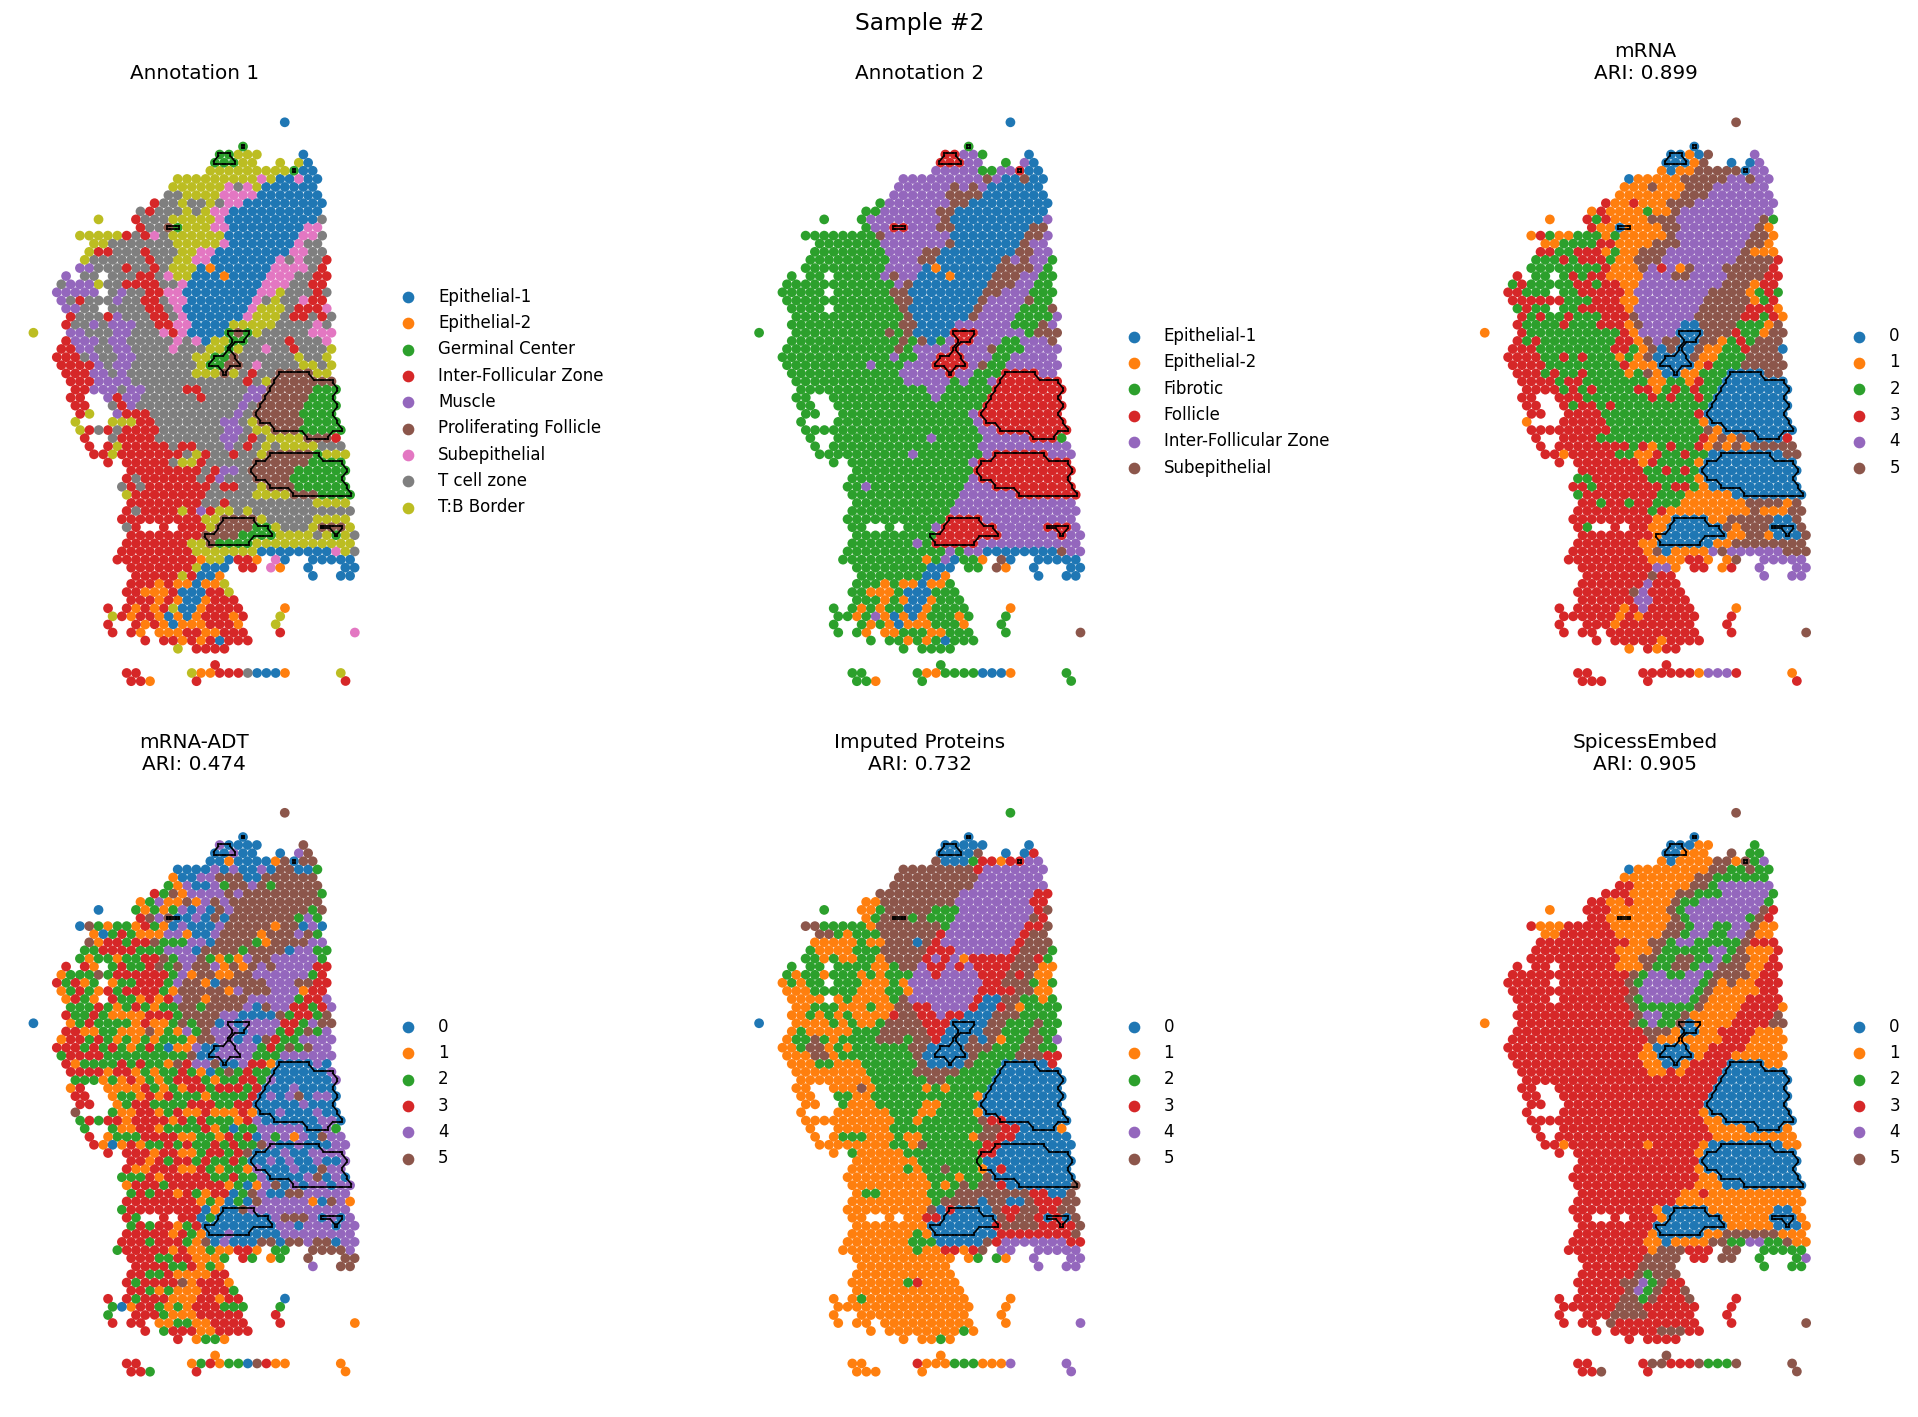

In [14]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 120

f, axs = plt.subplots(2, 3)
    
sample = tonsils_loader.sample_ids.index(adata_tmp.obs.sample_id.unique()[0])

sq.pl.spatial_scatter(
    adata_tmp, 
    layer='normalized',
    frameon=False,
    color=['annotation_20220215', 'annotation_20220527']+titles,
    # color=titles,
    title=['Annotation 1', 'Annotation 2']+\
    [x.replace('Imputed', 'Imputed Proteins')+'\nARI: '+f'{metrics.loc[x].ARI:.3f}' for x in titles],
    img=False, size=45, ax=axs.flatten(), fig=f)



points, edges = find_edges(adata_tmp, sections=['Germinal Center', 'Proliferating Follicle'], alpha=5)
# points, edges = find_edges(adata_tmp, sections=['Germinal Center'], alpha=5)

for ii, jj in edges:
    for a in axs.flatten():
        a.plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=1, color='black')

f.suptitle(f'Sample #{sample+1}', fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
ix = 6
adata_tmp = tonsils_loader.run(ix)
titles = list(embed_dict[f'sample_{ix}'].keys())
targets = list(embed_dict[f'sample_{ix}'].values())
adata_tmp = cluster_adata(adata_tmp.copy(), targets, titles, k=6)

In [16]:
metrics = gc_metrics(adata_tmp)
metrics.sort_values(by='ARI', ascending=False)

,ARI,JI,NMI
mRNA,0.882910,0.884314,0.781919
SpicessEmbed,0.724515,0.752883,0.625046
Imputed,0.524022,0.564860,0.347238
mRNA-ADT,0.377501,0.423394,0.209670


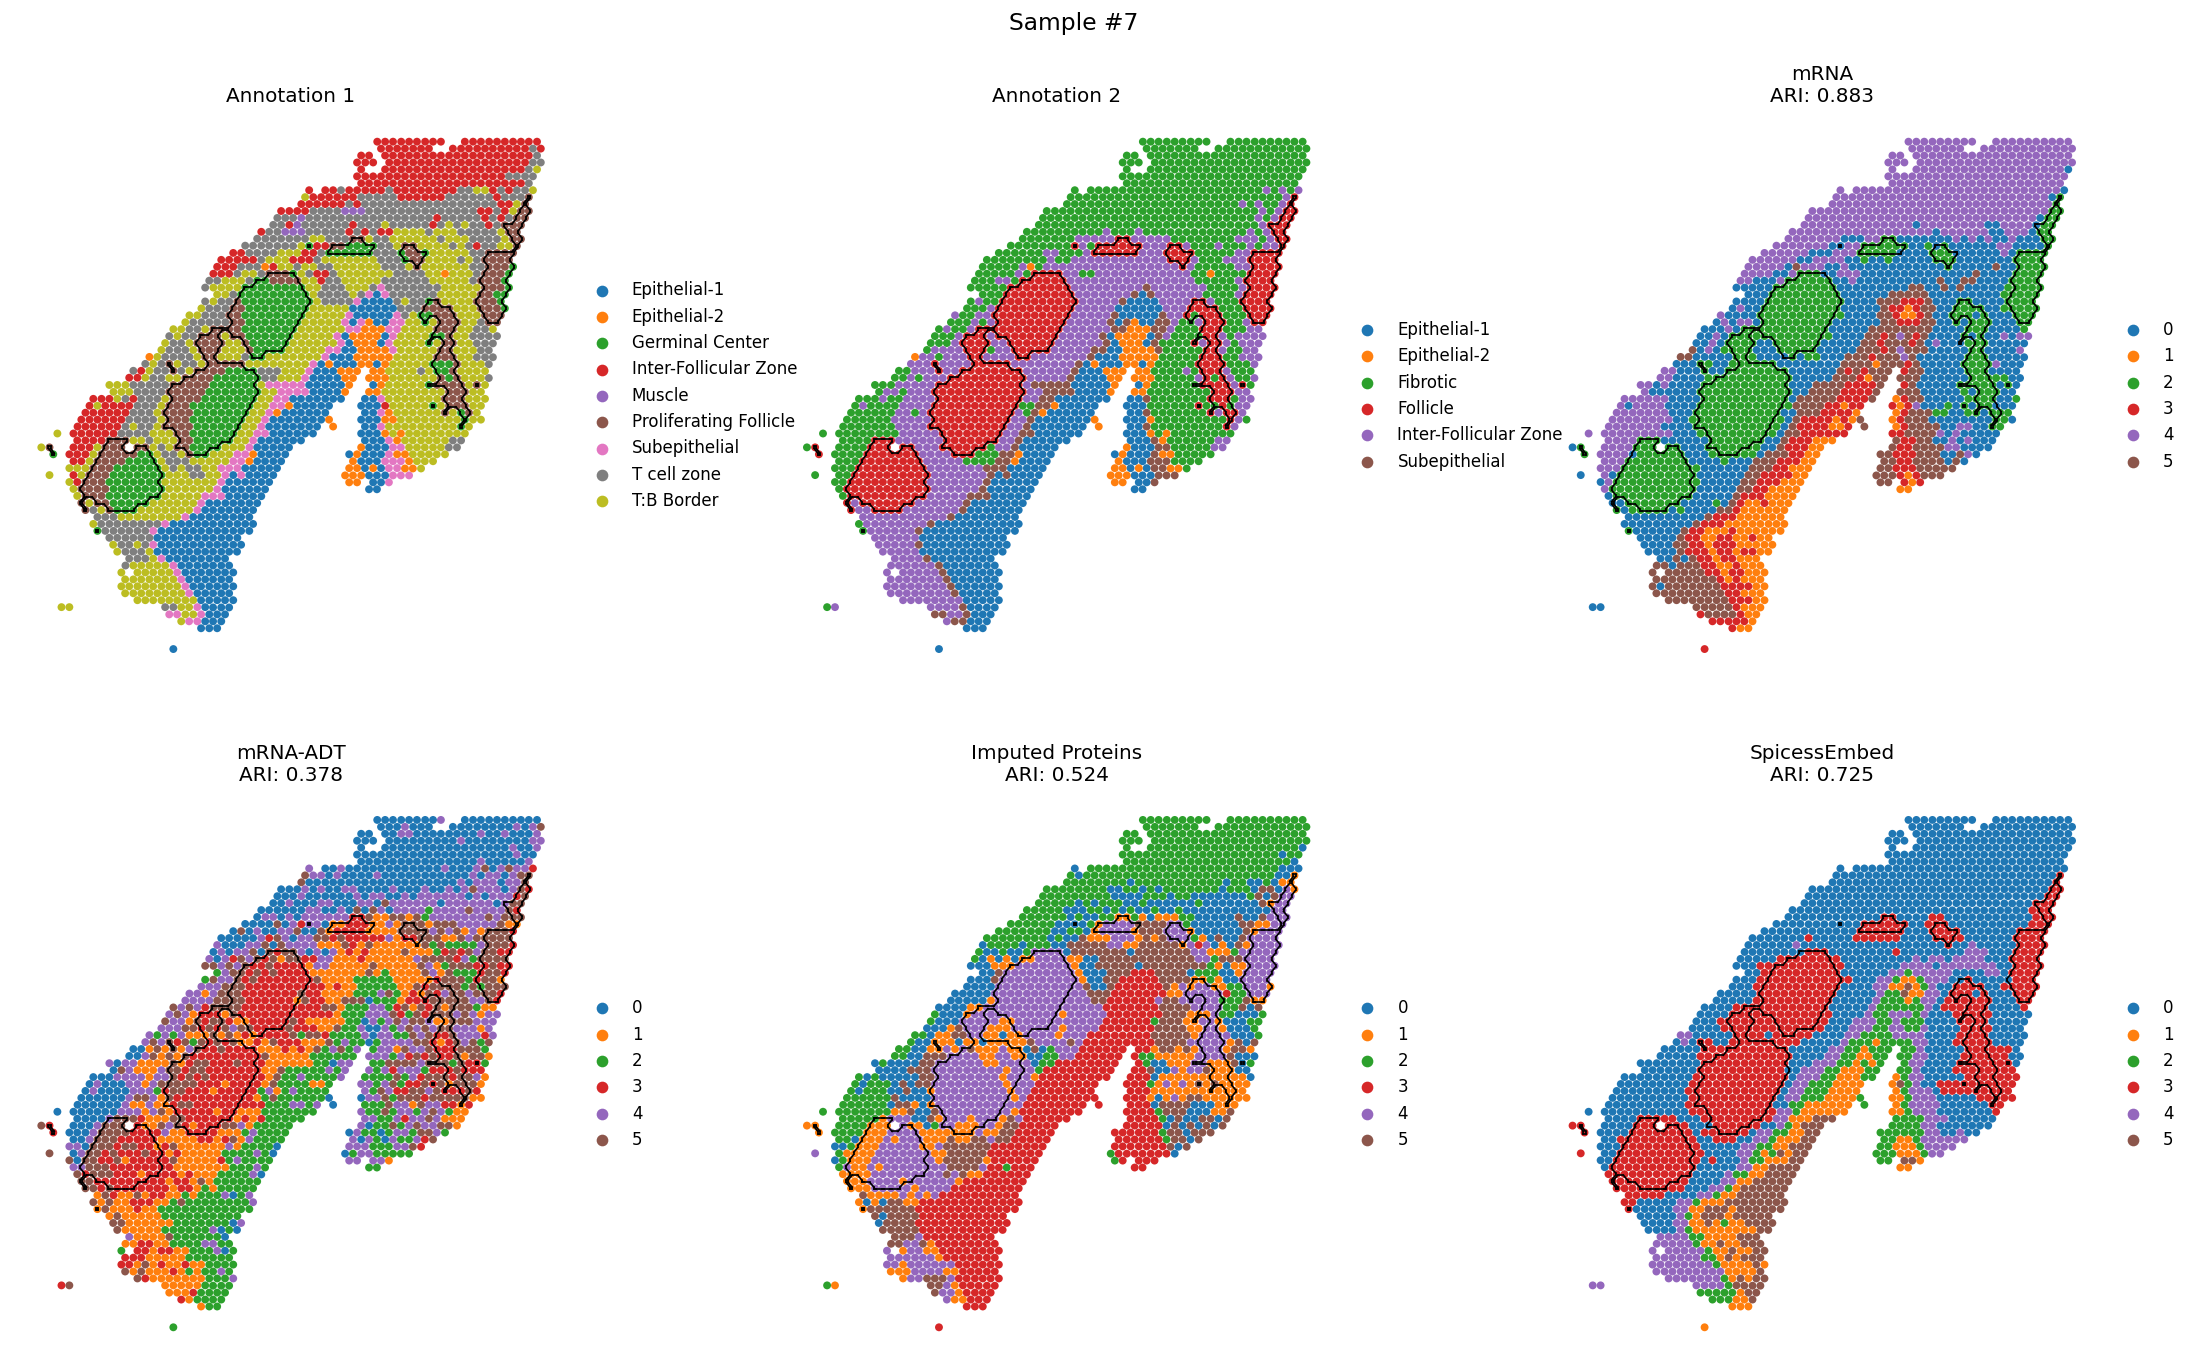

In [17]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 120

f, axs = plt.subplots(2, 3)
    
sample = tonsils_loader.sample_ids.index(adata_tmp.obs.sample_id.unique()[0])

sq.pl.spatial_scatter(
    adata_tmp, 
    layer='normalized',
    frameon=False,
    color=['annotation_20220215', 'annotation_20220527']+titles,
    # color=titles,
    title=['Annotation 1', 'Annotation 2']+\
    [x.replace('Imputed', 'Imputed Proteins')+'\nARI: '+f'{metrics.loc[x].ARI:.3f}' for x in titles],
    img=False, size=25, ax=axs.flatten(), fig=f)



points, edges = find_edges(adata_tmp, sections=['Germinal Center', 'Proliferating Follicle'], alpha=5)
# points, edges = find_edges(adata_tmp, sections=['Germinal Center'], alpha=5)

for ii, jj in edges:
    for a in axs.flatten():
        a.plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=1, color='black')

f.suptitle(f'Sample #{sample+1}', fontsize=14)
plt.tight_layout()
plt.show()